# PhosFinder

PhosFinder is a geospatial evaluation tool, developed by Strategic Systems Engineering, that estimates nutrient transport for Canadian domains.

In [3]:
from phosfinder import Dem
from phosfinder import Raster
from matplotlib import pyplot as plt
import rasterio
from rasterio.plot import show
import os

plt.rcParams['figure.figsize'] = [10, 10]
plt.set_cmap('viridis')

<Figure size 720x720 with 0 Axes>

## Functionality Overview

PhosFinder's main feature is to estimate the mass of **Nitrogen and Phosphorus** eroded and leaves the landscape by way of precipitation runoff. However, in order to make these calculations a number of datasets have to be made:


### Flow Routing
Firstly, PhosFinder has to find where precipitation is naturally routed based on elevation data. As such, PhosFinder will provide the user with native functions responsible for both **Flow Directions** and **Flow Accumulation** analysis. Both functions operate under the D8 method of routing runoff.

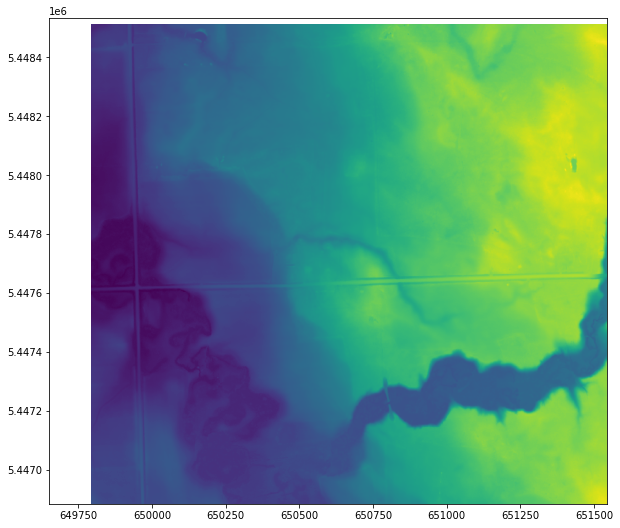

Filling sinks with minimun slope: 0.01 degress
Drainage Direction Assignment (D8)
Flow Accumulation
Drainage Feature


In [4]:
dem_name = 'tolstoi_small.tif'
show(rasterio.open(dem_name))


my_dem = Dem(dem_name)
my_dem.fill_sinks(0.01)


direction_array = my_dem.flow_direction()
accumulation_array = my_dem.flow_accumulation(direction_array)

output_name = dem_name.split(".")[0]
os.mkdir(output_name)
my_dem.output_raster(direction_array,output_name+"/flow_direction.tif")
my_dem.output_raster(accumulation_array,output_name+"/accumulation.tif")

### Travel Time Calculations

Next, we'll create an array of values representing the longest upstream distance at every pixel in a given watershed within the DEM's domain. We'll call this array the **Flow Lengths** array. This array provides information that'll help PhosFinder determine how intense the runoff flows across the landscape. This functions requires the Flow Direction array and the common outlet that drains watershed.

In [5]:
from phosfinder import NutrientMobility
coor = [650169,5447750]
flow_length_array = NutrientMobility.upstream_length(my_dem, direction_array, coor)

Determining the Upstream Flow Lengths of each pixel within the subbbasin of outlet 650169, 5447750


In [6]:
my_dem.output_raster(flow_length_array,output_name+"/flow_length_array.tif")
show(rasterio.open(output_name+"/flow_length_array.tif"))

<AxesSubplot:>

The **Surface Roughness** function determines the landscape's frictional force that is applied upon flowing runoff. For this function to operate, the user must provide a Flow Directions array and portion of the Annual Crop Inventory, 2019 version, that overlaps the domain.

In [7]:
aci_file = Raster('aci_2019_mb_reprojected.tif')

roughness_array = NutrientMobility.surface_roughness(my_dem, aci_file)

Determining Manning's Roughness Coefficient


The **Travel Time** function determine the amount of time it would take for runoff to travel to the outlet if rain landed anywhere within the watershed. For this function, we need the Flow Directions, Accumulation, Flow Lengths and Surface Roughness array. In addition, we need to provide the function the watershed's outlet coordinates and the domain's precipitation depth for a 24 hour storm, on a 2 Year return, provided in inches. The travel time function will determine time in units of hours.

In [8]:
travel_time_array = NutrientMobility.travel_time_downstream(my_dem, roughness_array, direction_array, accumulation_array, flow_length_array, 123, coor)

Calculating Travel Time, given a 123 inch rainfall event, given in hours


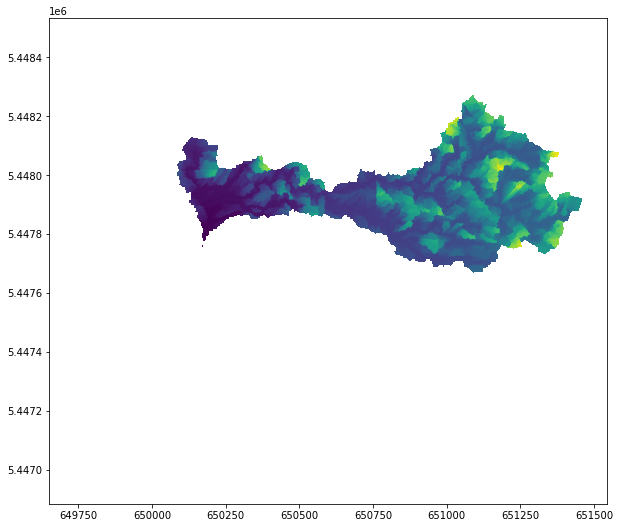

<AxesSubplot:>

In [9]:
my_dem.output_raster(travel_time_array,output_name+"/travel_time_array.tif")
show(rasterio.open(output_name+"/travel_time_array.tif"))

### Nutrient Transport

The **Nutrient Yield** functions estimates how much nitrogen **or** phosphorus is taken from the landscape per year. Again, this function require the Annual Crop Inventory raster and the Flow Directions array.

In [10]:
#Total Nitrogen
nitrogen_yield = NutrientMobility.tn_yield(my_dem, aci_file)

#Total Phosphorus
phosphorus_yield = NutrientMobility.tp_yield(my_dem, aci_file)

Determining yearly Total Nitrogen loss (in grams) per pixel
Determining yearly Total Phosperus loss (in grams) per pixel


The **Nutrient Mass** raster estimates mass of the eroded nutrient masses is taken and transported by runoff. To execute this function, the user must provide the Nutrient Yield raster, the Time Travel raster, the unit of time the time travel values represent, and the flow accumulation array. As a reminder, Time Travel rasters generated by PhosFinder are in units of hours.

In [13]:
loss_array = NutrientMobility.nutrient_mass(my_dem,phosphorus_yield, travel_time_array, 'hours', accumulation_array)

Calculating Nutrient Transport


In [15]:
my_dem.output_raster(loss_array,output_name+"/loss_raster.tif")
show(rasterio.open(output_name+"/loss_raster.tif"))

/Users/sharma/opt/anaconda3/envs/gdal/lib/python3.9/site-packages/matplotlib/image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


<AxesSubplot:>

The **Nutrient Accumulation** raster determines the accumulated nutrient mass that'll be transported by runoff at each point of the watershed. Simply put, this function operates under the same logic as the Flow Accumulation array, but re-purposed for nutrient transport. As such, the function requires the Nutrient Loss array, the Flow Directions array, the watershed outlet coordinates.

In [16]:
nutrient_acc_raster = NutrientMobility.nutrient_accumulation(my_dem,loss_array,direction_array,coor)

Calculating Accumulated Nutrient Mass 
(259, 392)


In [17]:
my_dem.output_raster(nutrient_acc_raster,output_name+"/nutrient_acc_raster.tif")
show(rasterio.open(output_name+"/nutrient_acc_raster.tif"))

<AxesSubplot:>